In [1]:
import time
import cv2
import os
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from skimage.feature import hog, local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

In [2]:
DATA_FOLDER = "caltech_101/"
label = [f_name for f_name in sorted(os.listdir(DATA_FOLDER))]
label.remove('BACKGROUND_Google')
print(label)

['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

In [3]:
IMG_SIZE = 200

caltech = []

for category in label:
    folder = DATA_FOLDER + category + '/'
    cate = label.index(category)
    for img in os.listdir(folder):
        img_arr = cv2.resize(cv2.imread(folder + img), (IMG_SIZE, IMG_SIZE))
        caltech.append([img_arr, cate])
        
random.Random(0).shuffle(caltech)

all_x = []
all_y = []

for images, labels in caltech:
    all_x.append(images)
    all_y.append(labels)
    
all_x = np.array(all_x)
all_y = np.array(all_y)

x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.33, random_state=42, shuffle=False)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5813, 200, 200, 3)
(5813,)
(2864, 200, 200, 3)
(2864,)


In [4]:
def showimage(image, train):
    if train == True:
        plt.imshow(x_train[image])
        plt.axis('off')
        plt.show()
        return (label[y_train[image]])
    else:
        plt.imshow(x_test[image])
        plt.axis('off')
        plt.show()
        return (label[y_test[image]])

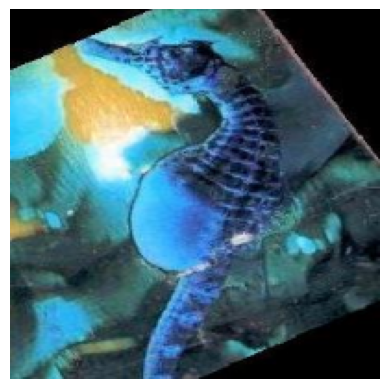

'sea_horse'

In [5]:
showimage(0,1)

# Grayscale

In [7]:
def gray(train, test):
    
    train_gray = []
    test_gray = []

    for image in train:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        train_gray.append(image_gray)

    for image in test:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        test_gray.append(image_gray)
        
    return np.array(train_gray), np.array(test_gray)

# Flatten

In [9]:
def flatten(train, test):
    
    return train.reshape(train.shape[0], -1), test.reshape(test.shape[0], -1)

# PCA

In [11]:
def pca(train, test, variance):
    
    train_flatten, test_flatten = flatten(train, test)
    
    pca = PCA(n_components = variance)
    pca.fit(train_flatten)
    
    return pca.transform(train_flatten), pca.transform(test_flatten)

# SIFT

In [13]:
def sift(train, test, num_cluster):
    
    sift = cv2.SIFT_create()
    
    sift_descriptors_train = []
    for image in train:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_train.append(des)
        
    sift_descriptors_test = []
    for image in test:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_test.append(des)
        
    sift_all_descriptors = []
    for descriptor in sift_descriptors_train:
        if descriptor is not None:
            for des in descriptor:
                sift_all_descriptors.append(des)
                
    sift_bow_dict = []
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(sift_all_descriptors)
    sift_bow_dict = kmeans.cluster_centers_
    
    train_sift = []
    for image in sift_descriptors_train:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        train_sift.append(features)

    test_sift = []
    for image in sift_descriptors_test:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        test_sift.append(features)
        
    return np.array(train_sift), np.array(test_sift)

# HOG

In [16]:
def c_hog(train, test, orientations, ppc, cpb):
    
    train_hog = []
    test_hog = []

    for image in train:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True, channel_axis=-1)
        train_hog.append(fd)

    for image in test:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True, channel_axis=-1)
        test_hog.append(fd)
        
    return np.array(train_hog), np.array(test_hog)

# LBP

In [18]:
def lbp(train, test, radius, flat):

    train_gray, test_gray = gray(train, test)
    train_lbp = []
    test_lbp = []

    for image in train_gray:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        train_lbp.append(lbp)

    for image in test_gray:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        test_lbp.append(lbp)
        
    train_lbp = np.array(train_lbp)
    test_lbp = np.array(test_lbp)
        
    if flat == True:
        return flatten(train_lbp.round().astype(np.uint8), test_lbp.round().astype(np.uint8))
    else:
        return train_lbp.round().astype(np.uint8), test_lbp.round().astype(np.uint8)

# SIFT + LBP

In [ ]:
def siftlbp(train, test, num_cluster, radius):
    
    train_siftlbp, test_siftlbp = lbp(train, test, radius, 0)
    
    return sift(train_siftlbp, test_siftlbp, num_cluster)

# HOG + LBP

In [ ]:
def hoglbp(train, test, orientations, ppc, cpb, radius):
    
    train_lbp, test_lbp = lbp(train, test, radius, 0)
    
    train_hoglbp = []
    test_hoglbp = []

    for image in train_lbp:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        train_hoglbp.append(fd)

    for image in test_lbp:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        test_hoglbp.append(fd)
        
    return np.array(train_hoglbp), np.array(test_hoglbp)

# Gaussian Process

In [ ]:
train_gpc, test_gpc = siftlbp(x_train, x_test, 25, 3)

In [ ]:
print(train_gpc.shape)
print(test_gpc.shape)

In [ ]:
N = 2500
x = train_gpc[:N]
y = y_train[:N]

In [ ]:
start = time.time()
kernel = RationalQuadratic()
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(x, y)
end = time.time()
print(datetime.timedelta(seconds = int(end-start)))

In [ ]:
y_pred = gpc.predict(test_gpc)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))